In [13]:
import os
import random
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm import tqdm  # Import tqdm for progress bars

In [14]:


# --- Device Configuration ---
def get_device():
    """Determines the available device (MPS, CUDA, or CPU) and returns it."""
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("MPS device found.")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA device found.")
    else:
        device = torch.device("cpu")
        print("No MPS or CUDA device found, using CPU.")
    print(f"Using device: {device}")
    return device

In [15]:
# --- Data Loading and Preprocessing ---

class FaceMaskDataset(Dataset):
    def __init__(self, data_dir, img_size=(256, 256), transform=None):
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform
        self.image_paths, self.mask_paths = self._load_data()
        print(f"Found {len(self.image_paths)} image-mask pairs.")

    def _load_data(self):
        print("Loading data...")
        image_paths = []
        mask_paths = []
        
        for subdir in os.listdir(self.data_dir):
            subdir_path = os.path.join(self.data_dir, subdir)
            if os.path.isdir(subdir_path):
                face_crop_path = os.path.join(subdir_path, "face_crop")
                face_crop_seg_path = os.path.join(subdir_path, "face_crop_segmentation")

                if os.path.exists(face_crop_path) and os.path.exists(face_crop_seg_path):
                    for img_name in os.listdir(face_crop_path):
                        if img_name.endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(face_crop_path, img_name)
                            mask_path = os.path.join(face_crop_seg_path, img_name)

                            if os.path.exists(mask_path):
                                image_paths.append(img_path)
                                mask_paths.append(mask_path)
        return image_paths, mask_paths



    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            raise ValueError(f"Could not load image or mask: {img_path} or {mask_path}")

        img = cv2.resize(img, self.img_size)
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        mask = np.expand_dims(mask, axis=-1)

        img = torch.from_numpy(img).permute(2, 0, 1)  # HWC to CHW
        mask = torch.from_numpy(mask).permute(2, 0, 1)

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask


In [16]:

# --- UNet Model (PyTorch) ---
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), # Added Batch Normalization
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [17]:


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = DoubleConv(in_channels, 64)
        self.conv2 = DoubleConv(64, 128)
        self.conv3 = DoubleConv(128, 256)
        self.conv4 = DoubleConv(256, 512)
        self.conv5 = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dconv4 = DoubleConv(1024, 512)
        self.dconv3 = DoubleConv(512, 256)
        self.dconv2 = DoubleConv(256, 128)
        self.dconv1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)

        # Decoder
        x = self.upconv4(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dconv4(x)

        x = self.upconv3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dconv3(x)

        x = self.upconv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dconv2(x)

        x = self.upconv1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dconv1(x)

        x = self.final_conv(x)
        return torch.sigmoid(x)

In [18]:
def train_unet(data_dir, device, img_size=(256, 256), batch_size=8, epochs=50, learning_rate=1e-4, checkpoint_path="unet_checkpoint.pth", patience=5):
    """Trains the UNet model with early stopping, ensuring checkpoint saving on early stop."""
    print("Starting train_unet function...")

    dataset = FaceMaskDataset(data_dir, img_size)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    model = UNet().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Load checkpoint if exists
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Loaded checkpoint from epoch {start_epoch - 1}")

    print("Starting training loop...")
    best_val_loss = float('inf')
    epochs_no_improve = 0
    final_checkpoint_saved = False

    for epoch in range(start_epoch, epochs):
        print(f"  Starting epoch {epoch+1}/{epochs}")
        model.train()
        train_loss = 0.0
        
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs} [Train]") as pbar:
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                pbar.update(1)
                pbar.set_postfix({"loss": loss.item()})

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            with tqdm(total=len(val_loader), desc=f"Epoch {epoch+1}/{epochs} [Val]") as pbar:
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    val_loss += loss.item()
                    pbar.update(1)
                    pbar.set_postfix({"loss": loss.item()})

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0

            # Save best model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }, checkpoint_path)
            final_checkpoint_saved = True
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after epoch {epoch+1}!")
            if not final_checkpoint_saved:
                print("Saving final checkpoint before exiting due to early stopping...")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss
                }, checkpoint_path)
            break

    print("Finished train_unet function.")
    return model


In [19]:
def calculate_iou(pred_mask, gt_mask):
    """Computes Intersection over Union (IoU) score."""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0.0

def calculate_dice(pred_mask, gt_mask):
    """Computes Dice coefficient."""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    return (2. * intersection) / (pred_mask.sum() + gt_mask.sum()) if (pred_mask.sum() + gt_mask.sum()) != 0 else 0.0

In [20]:


def visualize_segmentation(model, device, images, masks, num_samples=10):
    """Visualizes segmentation results and calculates IoU and Dice scores."""
    model.eval()
    random_indices = random.sample(range(len(images)), num_samples)

    for i in random_indices:
        img = images[i]
        gt_mask = masks[i]

        with torch.no_grad():
            img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)
            pred_mask = model(img_tensor).squeeze(0).cpu().numpy()
            pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Calculate IoU and Dice
        iou = calculate_iou(pred_mask, gt_mask)
        dice = calculate_dice(pred_mask, gt_mask)

        # Visualization
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title(f"Predicted Mask\nIoU: {iou:.4f}, Dice: {dice:.4f}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        print(f"Sample {i} - IoU: {iou:.4f}, Dice: {dice:.4f}")


In [21]:
# # --- Main Execution ---

# if __name__ == "__main__":
#     # Get the device only once in the main process
#     device = get_device()

#     # --- Kaggle Specific Change ---
#     data_dir = "/kaggle/input/msfd-data/MSFD"  # Path to your dataset directory on Kaggle
#     checkpoint_path = "unet_checkpoint.pth"
#     # --- End Kaggle Specific Change ---
#     img_size = (256,256)

#     # Check if training should resume
#     # --- Kaggle Specific Change ---
#     kaggle_checkpoint_path = os.path.join("/kaggle/working/", checkpoint_path)
#     if os.path.exists(kaggle_checkpoint_path):
#         resume_training = input("Checkpoint found. Resume training? (y/n): ")
#         if resume_training.lower() == 'y':
#             print("Resuming training...")
#             model = train_unet(data_dir, device, img_size, epochs=50, checkpoint_path=checkpoint_path)
#         else:
#             print("Starting new training...")
#             model = train_unet(data_dir, device, img_size, epochs=50, checkpoint_path=checkpoint_path)
#     else:
#         print("No checkpoint found. Starting new training...")
#         model = train_unet(data_dir, device, img_size, epochs=50, checkpoint_path=checkpoint_path)
#     # --- End Kaggle Specific Change ---

#     # Load all data for visualization
#     all_dataset = FaceMaskDataset(data_dir, img_size)
#     all_images = []
#     all_masks = []
#     for i in tqdm(range(len(all_dataset)), desc="Loading all data for visualization"):
#         img, mask = all_dataset[i]
#         all_images.append(img.permute(1,2,0).numpy())
#         all_masks.append(mask.permute(1,2,0).numpy())

#     # Visualize segmentation on random samples
#     visualize_segmentation(model, device, all_images, all_masks, num_samples=10)


CUDA device found.
Using device: cuda


KeyboardInterrupt: Interrupted by user

<ipython-input-33-e7b8341049f2>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint from epoch 18


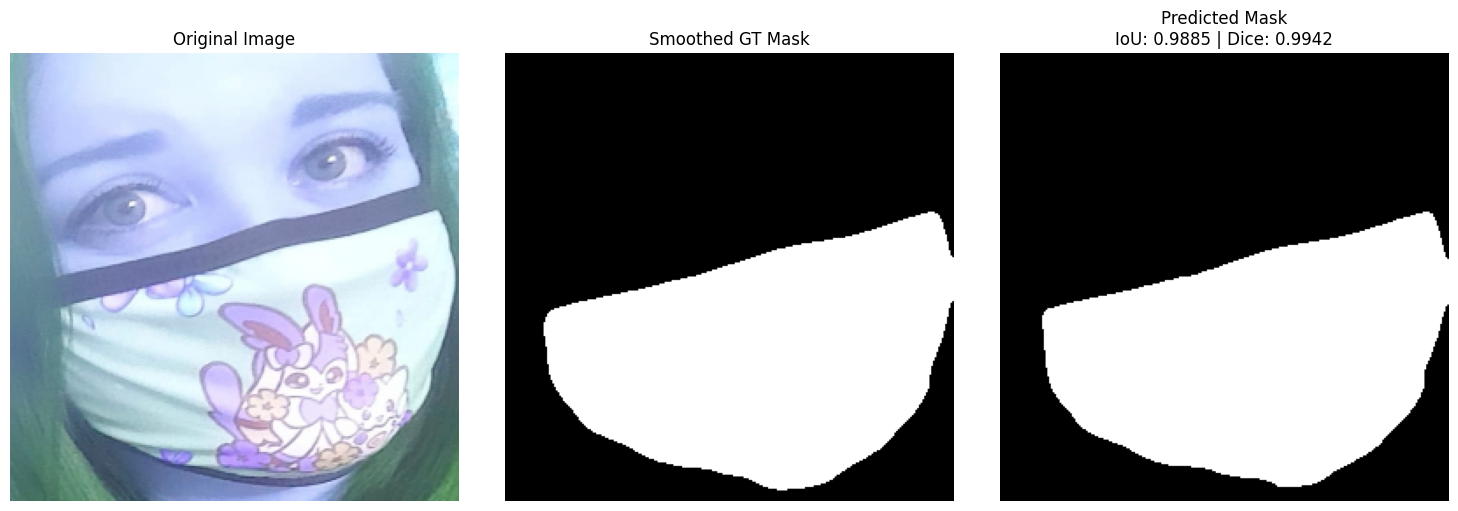

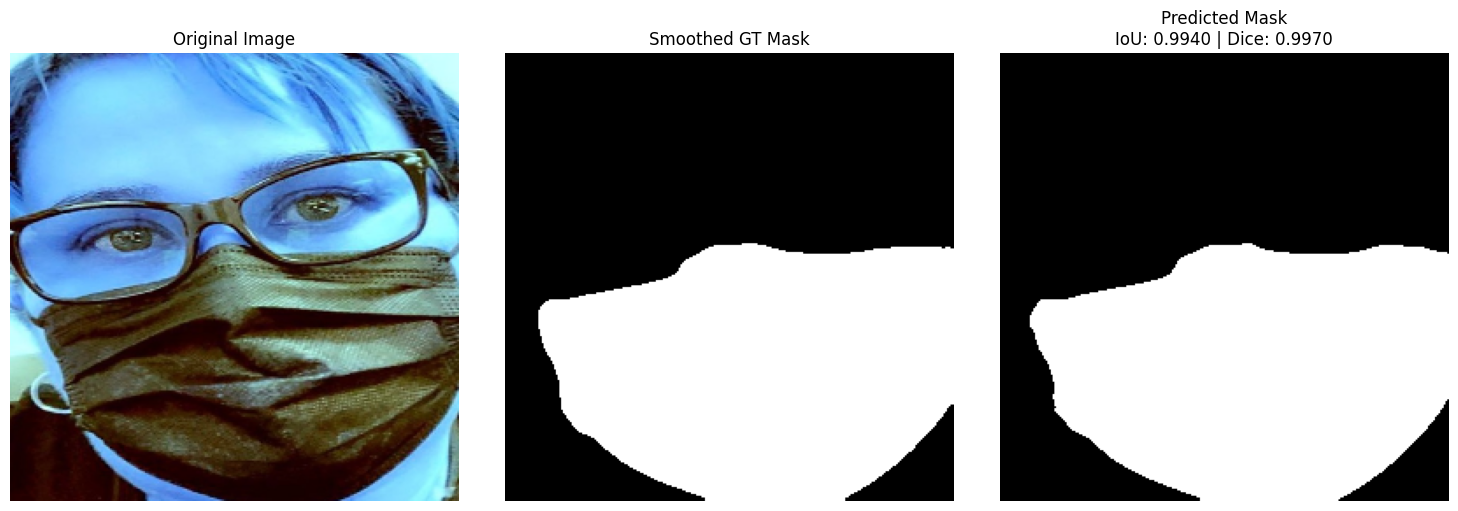

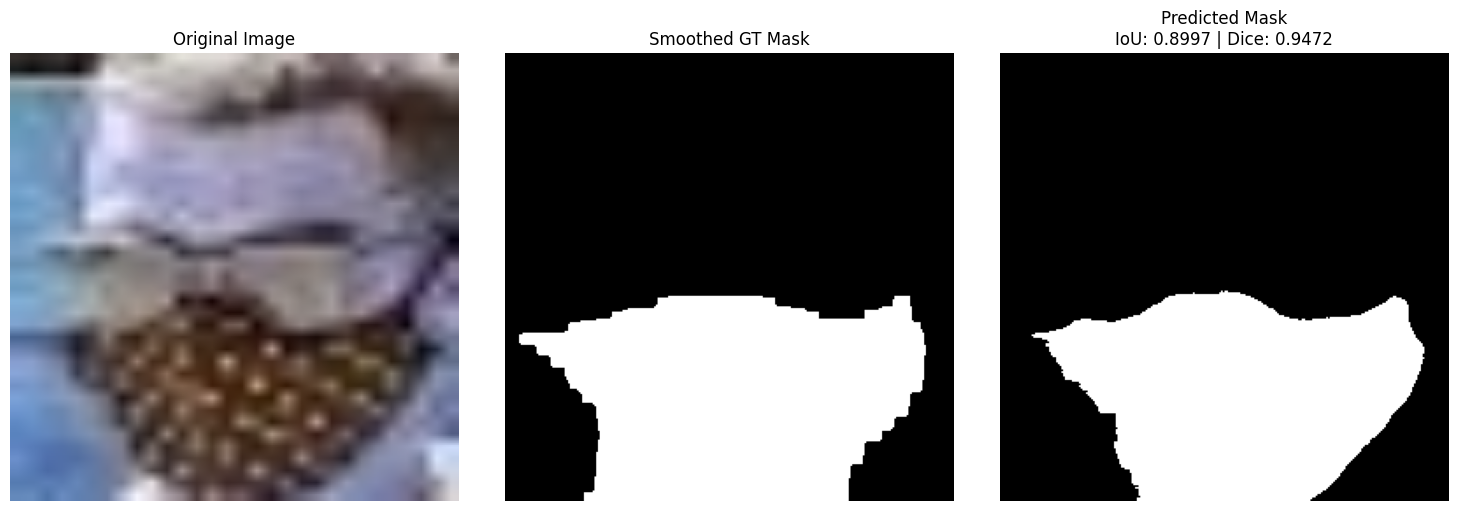

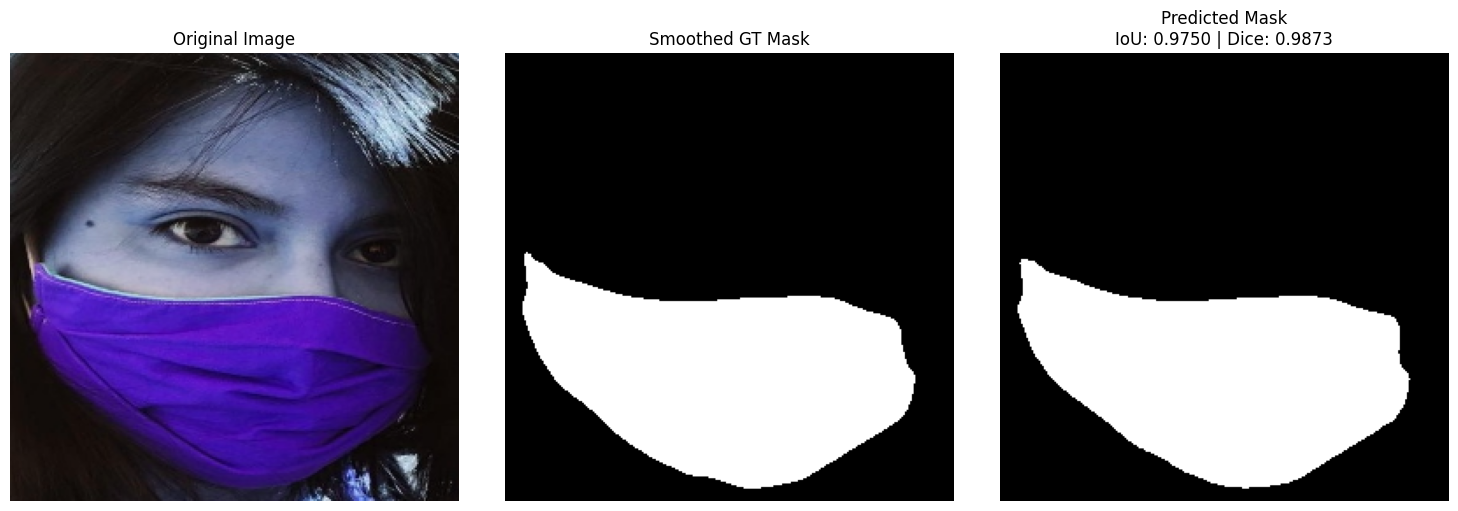

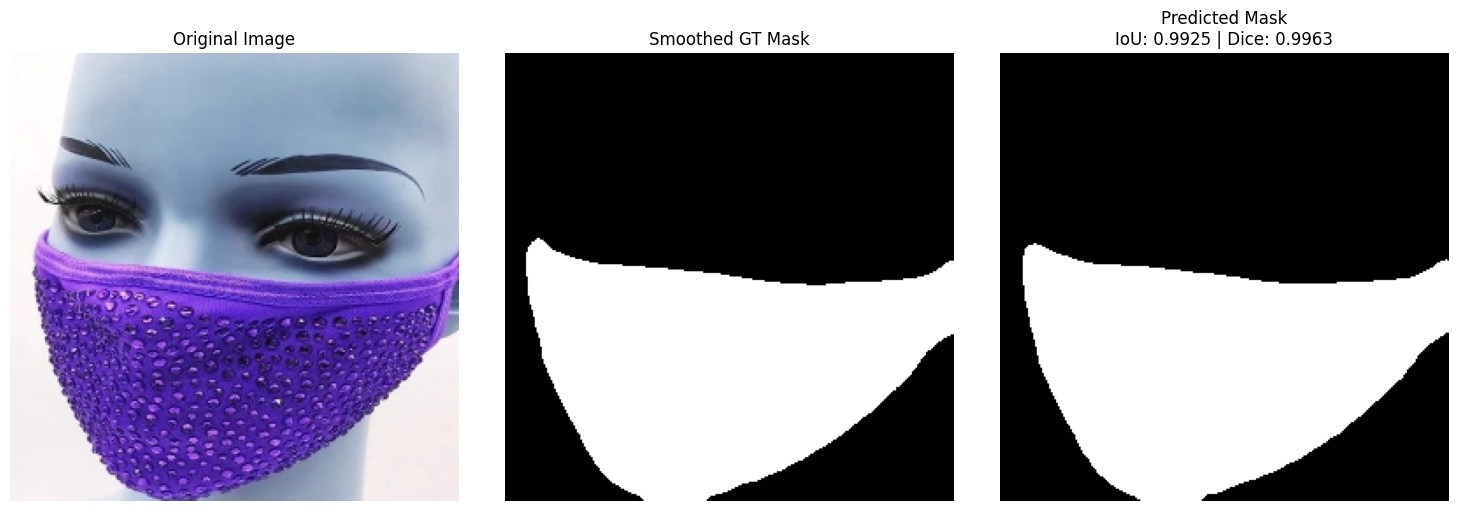

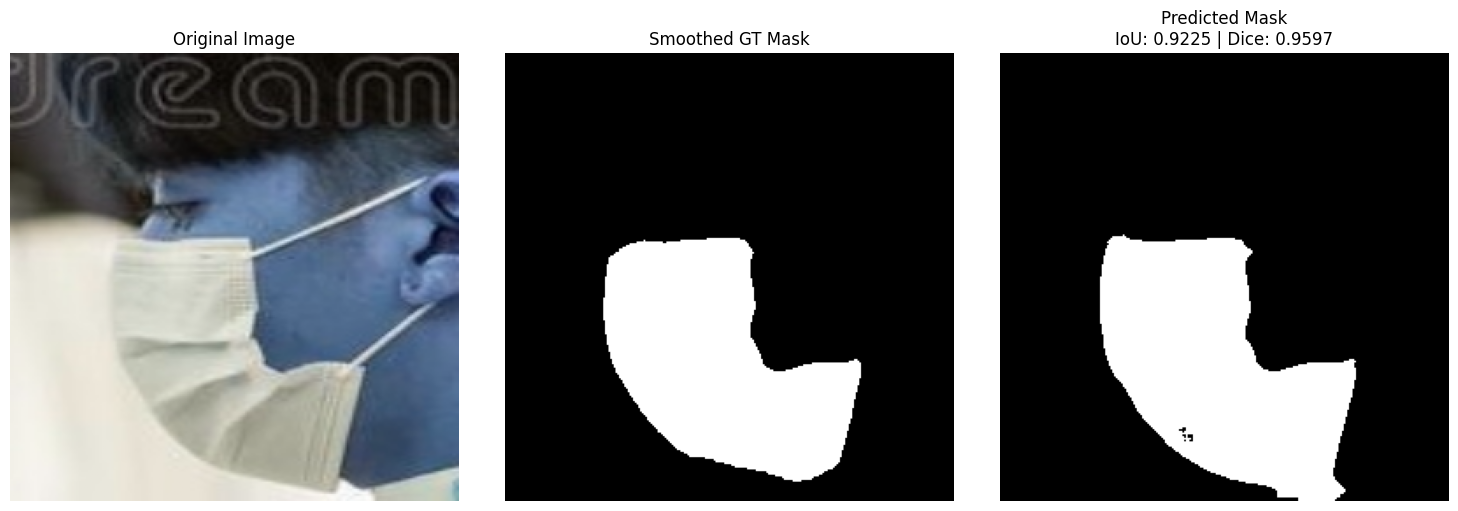

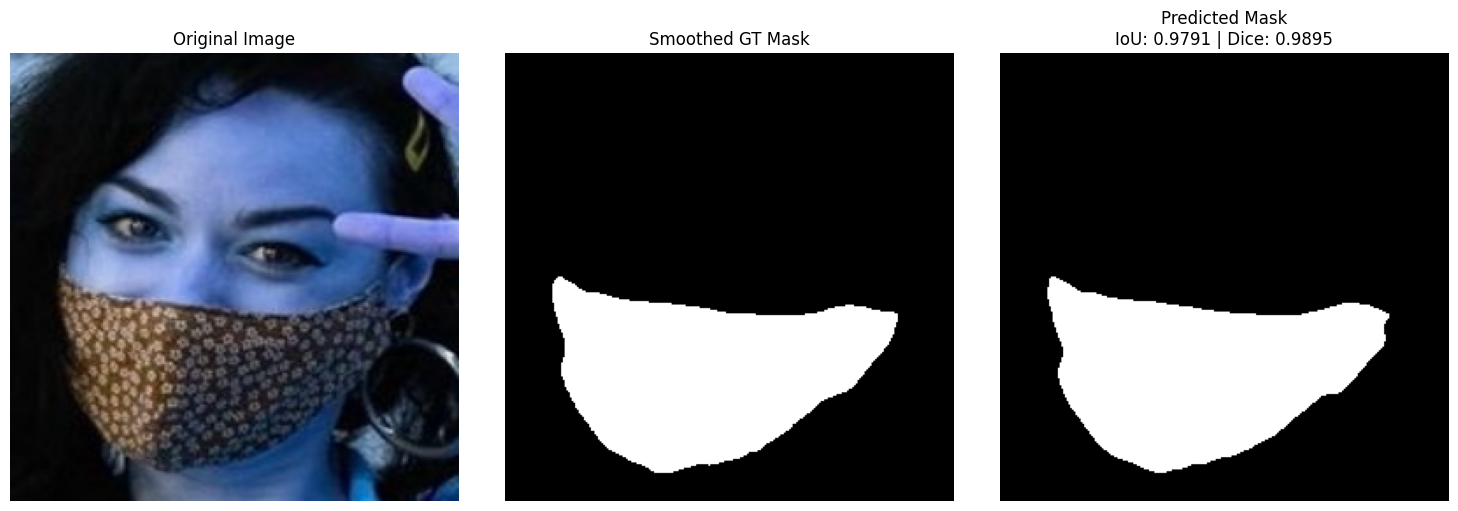

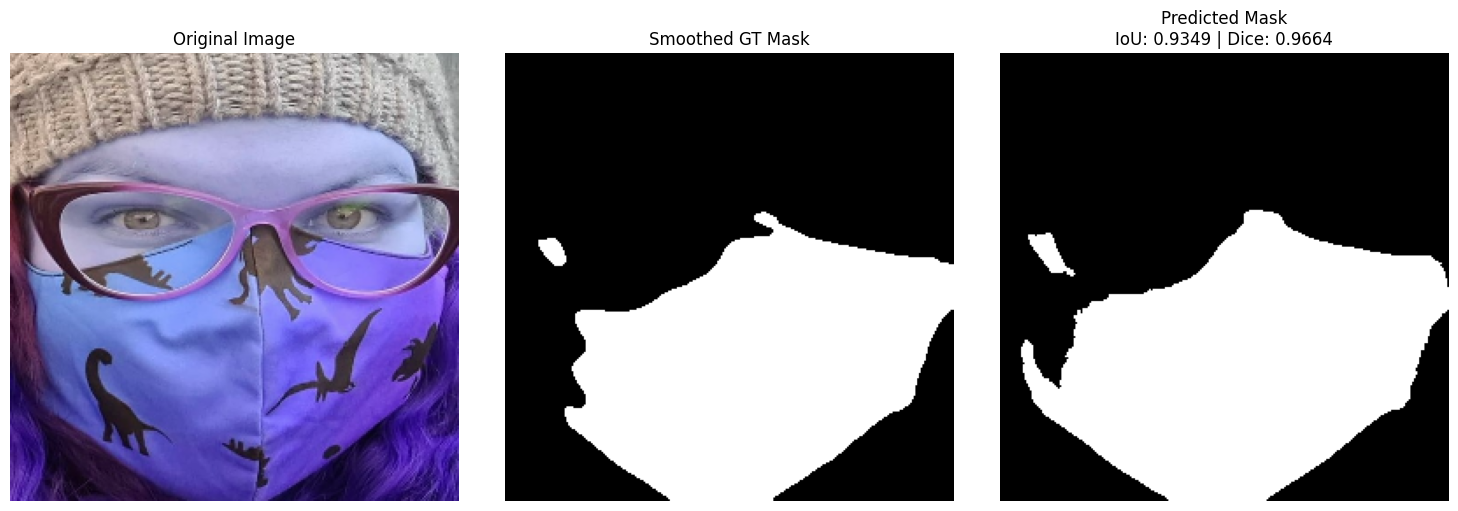

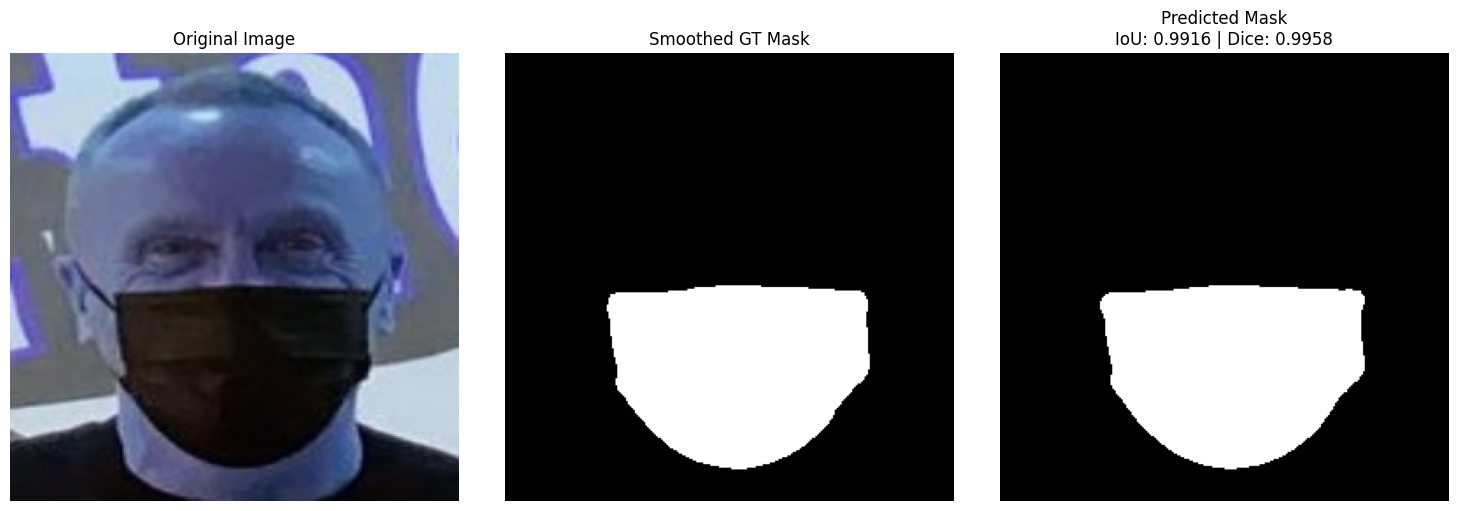

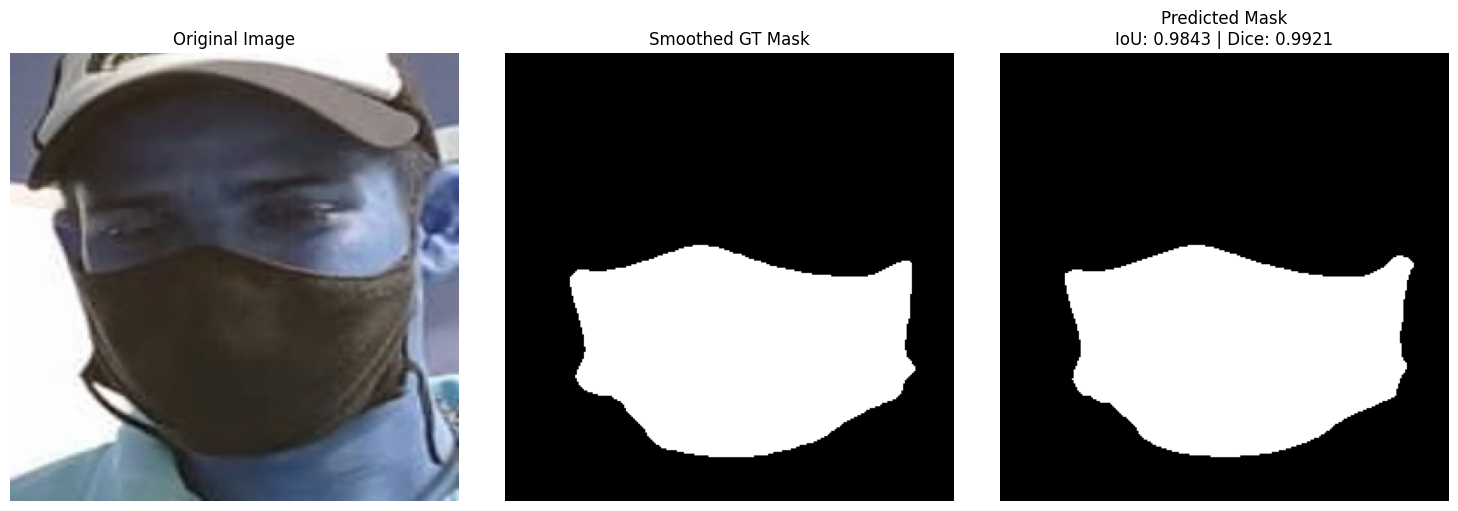

In [33]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2

from skimage.metrics import adapted_rand_error
from scipy.spatial.distance import dice

# --- Step 1: Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Step 2: Initialize the Model ---
model = UNet()  # Ensure your UNet class is correctly defined
model.to(device)

# --- Step 3: Load Checkpoint ---
checkpoint_path = "/kaggle/working/unet_checkpoint.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")

model.eval()  # Set to evaluation mode


# Compute IoU
def compute_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0
    
def compute_dice(pred_mask, gt_mask):
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    gt_mask = (gt_mask > 0.5).astype(np.uint8)
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    return 2 * intersection / (pred_mask.sum() + gt_mask.sum()) if (pred_mask.sum() + gt_mask.sum()) != 0 else 0




def infer_and_visualize(model, device, images, masks, num_samples=10):
    """Performs inference, computes IoU/Dice, and visualizes results."""
    random_indices = random.sample(range(len(images)), num_samples)

    for i in random_indices:
        img = images[i]
        gt_mask = masks[i]

        # Apply Gaussian Blur to smooth the ground truth mask
        gt_mask = cv2.GaussianBlur(gt_mask.astype(np.float32), (5, 5), 0)

        with torch.no_grad():
            img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().to(device)
            pred_mask = model(img_tensor).squeeze(0).cpu().numpy()
            
            # Threshold the predicted mask
            pred_mask = (pred_mask > 0.5) * 255
            pred_mask = pred_mask.astype(np.uint8)

        # Ensure ground truth mask is in the correct format after smoothing
        gt_mask = (gt_mask > 0.5) * 255
        gt_mask = gt_mask.astype(np.uint8)

        # Compute IoU & Dice Scores
        iou_score = compute_iou(pred_mask, gt_mask)
        dice_score = compute_dice(pred_mask, gt_mask)

        # Plot Results
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.squeeze(), cmap="gray")
        plt.title("Smoothed GT Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title(f"Predicted Mask\nIoU: {iou_score:.4f} | Dice: {dice_score:.4f}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

infer_and_visualize(model, device, all_images, all_masks)